In [303]:
import numpy as np
import time
import scipy.special
# scipy.ndimage for rotating image arrays
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [304]:
class NeuralNetwork:
    
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        self.inodes = inputnodes   # 输入层节点数
        self.hnodes = hiddennodes  # 隐藏层节点数
        self.onodes = outputnodes  # 输出层节点数
        self.lr = learningrate     # 学习率
        
        # 权重矩阵初始化（xavier）
        self.wih = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        self.wih_inv = None
        self.who_inv = None
        
        # 激活函数
        self.activation_function = lambda x: scipy.special.expit(x)  # Sigmoid函数
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
    
    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        # 前向传播 (不用query是因为要用到中间结果)
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        # 误差反向传播
        output_errors = targets - final_outputs  # 输出层误差（这里默认了loss为均方差）
        hidden_errors = np.dot(self.who.T, output_errors)  # 隐藏层误差
        
        # 根据输出层误差，更新隐藏层到输出层的权重（△W = α*E*O_k*(1-O_k)·O_h）
        self.who += self.lr * np.dot(output_errors * final_outputs * (1.0 - final_outputs), hidden_outputs.T)
        
        # 根据隐藏层误差，更新输入层到隐藏层的权重
        self.wih += self.lr * np.dot(hidden_errors * hidden_outputs * (1.0 - hidden_outputs), inputs.T)
        return output_errors
    
    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T  # 将输入列表转换成数组(nx1)，以便后面数组相乘
        
        # 隐藏层
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # 输出层
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    
    def scaleto(x, min_x, max_x):
        x -= np.min(x)
        x /= np.max(x)
        x *= 0.98
        x += 0.01
    
    # 向后查询
    # x = ln[y/(1-y)]
    def backquery(self, outputs):
        final_outputs = np.array(outputs, ndmin=2).T
        final_inputs = self.inverse_activation_function(final_outputs)
        
        hidden_outputs = np.dot(self.who.T, final_inputs)
        hidden_outputs -= np.min(hidden_outputs)
        hidden_outputs /= np.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        inputs = np.dot(self.wih.T, hidden_inputs)
        inputs -= np.min(inputs)
        inputs /= np.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        inputs_list = inputs.T[0]
        return inputs_list
        
        

In [305]:
# 超参数设置
# 网络结构参数
input_nodes = 784 # 28 x 28
hidden_nodes = 200
output_nodes = 10

# 训练参数
epochs = 10
learning_rate = 0.01

n = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [306]:
# 加载训练数据
train_data_list = None
with open("mnist_train.csv", 'r') as data_file:
    train_data_list = data_file.readlines()

# 加载验证数据
test_data_list = None
with open("mnist_test.csv", 'r') as file:
    test_data_list = file.readlines()

In [307]:
# 训练。遍历训练数据训练网络。
print('start training...')
step = 0
time_start = time.time()
for e in range(epochs):
    step = 0
    for record in train_data_list:
        all_values = record.split(',')
        label = int(all_values[0])  # 标签 
        img_data = np.asfarray(all_values[1:])   # 图片数据（784 x 1）
        # 因为sigmoid的输出范围为(0, 1)，因此调整输入值范围为(0.01, 0.99)，便于网络训练（输入和输出形状类似，便于网络训练）
        inputs = img_data / 255.0 * 0.99 + 0.01
        # 使用Onehot Enhance作为标签，避免取到0，1是为了避免训练出过大的权重值
        targets = np.zeros(output_nodes) + 0.01
        targets[label] = 0.99
        n.train(inputs, targets)
        
        ## create rotated variations
        # rotated anticlockwise by x degrees
        inputs_plusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
        n.train(inputs_plusx_img.reshape(784), targets)
        # rotated clockwise by x degrees
        inputs_minusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)
        n.train(inputs_minusx_img.reshape(784), targets)

        step += 1
#         if step % 60000 == 0 or step == len(train_data_list) - 1:
#             print("step:{}, max error:{}".format(step, err.T.max()))
        if step == len(train_data_list) - 1:
            acc = calculate_accuracy()
            time_end = time.time()
            print("epochs:{}, acc:{}, elapse time:{:.3f} s".format(e+1, acc, time_end - time_start))
            time_start = time_end
print('end of training.')

start training...
epochs:1, acc:0.9444, elapse time:187.177 s
epochs:2, acc:0.9608, elapse time:156.613 s
epochs:3, acc:0.9673, elapse time:168.065 s
epochs:4, acc:0.9702, elapse time:134.299 s
epochs:5, acc:0.9723, elapse time:137.805 s
epochs:6, acc:0.9739, elapse time:144.601 s
epochs:7, acc:0.9748, elapse time:163.034 s
epochs:8, acc:0.9749, elapse time:159.502 s
epochs:9, acc:0.9761, elapse time:148.828 s
epochs:10, acc:0.9763, elapse time:134.989 s
end of training.


In [308]:
# 验证
def calculate_accuracy():
    scorecard = []
    for record in test_data_list:
        all_values = record.split(',')
        correct_label = int(all_values[0])
        img_data = np.asfarray(all_values[1:])
        inputs = img_data / 255.0 * 0.99 + 0.01
        outputs = n.query(inputs)
        predict_label = np.argmax(outputs)
    #     print('label:{}, predict:{}'.format(correct_label, predict_label))
        if correct_label == predict_label:
            scorecard.append(1)
        else:
            scorecard.append(0)
    # print(scorecard)
    acc = np.sum(scorecard) / len(scorecard)
    return acc

In [309]:
# 读取自己手写的图片
scorecard = []
for i in range(10):
    label = i# + 2
    img_name = 'my_images/{}.png'.format(label)
    img_data = mpimg.imread(img_name)
    inputs = 1.0 - np.array(img_data[:,:,0])
    inputs = np.clip(inputs, 0.01, 0.99).flatten()
    outputs = n.query(inputs)
    predict_label = np.argmax(outputs)
#     print('label:{}, predict:{}'.format(i, predict_label))
    if label == predict_label:
        scorecard.append(1)
    else:
        scorecard.append(0)
#         plt.figure()
#         plt.title('label:{}, predict:{}'.format(label, predict_label))
# #         print(outputs)
#         plt.imshow(img_data)
print(scorecard)
print('accurary:', np.sum(scorecard) / len(scorecard))
    

[1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
accurary: 0.5


In [310]:
def nn_backquery(nn, outputs):
    final_outputs = np.array(outputs, ndmin=2).T
    final_inputs = scipy.special.logit(final_outputs)

    who_inv = np.linalg.pinv(nn.who)
    wih_inv = np.linalg.pinv(nn.wih)
    hidden_outputs = np.dot(who_inv, final_inputs)
    hidden_outputs -= np.min(hidden_outputs)
    hidden_outputs /= np.max(hidden_outputs)
    hidden_outputs *= 0.98
    hidden_outputs += 0.01

    hidden_inputs = scipy.special.logit(hidden_outputs)

    inputs = np.dot(wih_inv, hidden_inputs)
    inputs -= np.min(inputs)
    inputs /= np.max(inputs)
    inputs *= 0.98
    inputs += 0.01

    inputs_list = inputs.T[0]
    return inputs_list

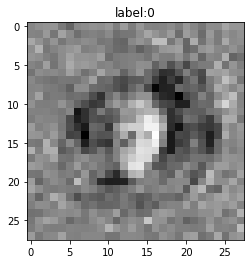

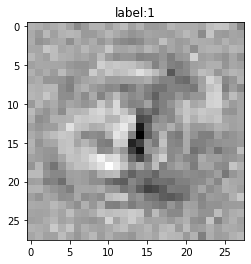

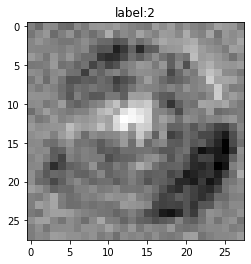

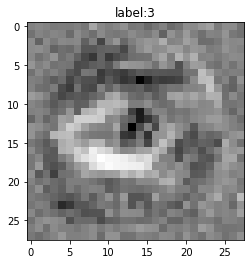

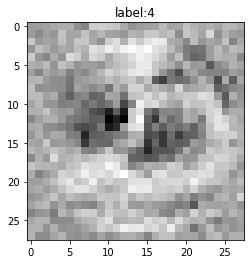

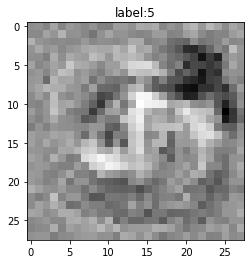

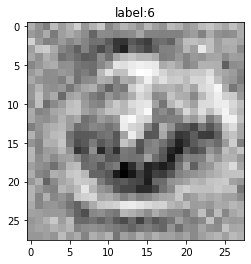

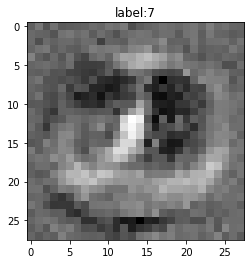

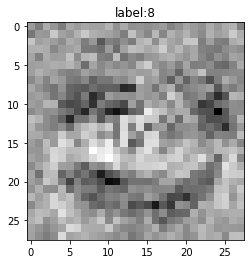

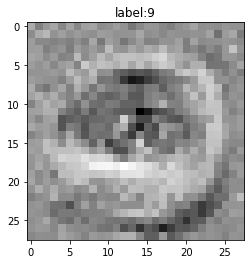

In [313]:
# 反向查询
for i in range(10):
    label = np.zeros(output_nodes) + 0.01
    label[i] += 0.98
    inputs = n.backquery(label)
#     inputs = nn_backquery(n, label)
    img_data = inputs.reshape((28, 28))
    plt.figure()
    plt.title('label:{}'.format(i))
    plt.imshow(img_data, cmap='Greys', interpolation=None)

In [ ]:
# 画出函数曲线
sigmoid = lambda x: scipy.special.expit(x)  # Sigmoid函数
sigmoid_inv = lambda x: scipy.special.logit(x)

def plot_fun(fun, x_min, x_max, title):
    x = np.linspace(x_min, x_max, 100)
    y = fun(x)
    plt.figure()
    plt.plot(x, y)
    plt.grid()
    plt.xlim(x_min, x_max)
    plt.xlabel('x')
    plt.title(title)

# plot_fun(sigmoid, -6, 6, 'expit(x)')
# plot_fun(sigmoid_inv, 0, 1, 'logit(x)')

# plot_fun(np.exp, -2, 2, 'np.exp(x)')
# plot_fun(np.log, 0.0001, 10, 'np.log(x)')